In [1]:
%matplotlib inline

import pyaudio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram

def play_sound(x, amp=0.5):

    p = pyaudio.PyAudio()
    # for paFloat32 sample values must be in range [-1.0, 1.0]
    stream = p.open(format=pyaudio.paFloat32,
                    channels=1,
                    rate=fs,
                    output=True)

    # play. May repeat with different volume values (if done interactively) 
    stream.write(amp*x)
    stream.stop_stream()
    stream.close()
    p.terminate()
    pass


def find_nearest(array, value):
    idx = (np.abs(array-value)).argmin()
    return idx


def make_sound(f, fs=44100, duration=1.0):
    # generate samples, note conversion to float32 array
    x = (np.sin(2*np.pi*np.arange(fs*duration)*f/fs)).astype(np.float32)
    return x


def complex_tone(freqs, amps, duration):
   # make tone
    tones = list()
    for amp, f in zip(amps, freqs):
        tones.append(make_sound(f, fs=fs, duration=duration)*amp)
    tone = np.array(tones).sum(0)  # sum the frequencies together
    return tone


def expspace(start, stop, num, density='natural'):
    lin = np.linspace(np.sqrt(start), np.sqrt(stop), num)
    if density == 'natural':
        return lin**2
    elif density == 'flip':
        shift = stop+start
        return (shift-(lin**2))[::-1]
    
def truncate_phase(signal, back_window=100, search_val=0):
    '''
    To remove popping sound, truncate the sound when phase is at 0
    '''
    
    idx = find_nearest(signal[-back_window:], search_val)
    truncate_idx = len(signal) + (-back_window+idx) + 1
    return signal[0:truncate_idx]    

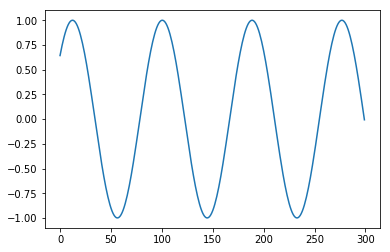

In [2]:
# show truncating function

# params
fs=44100  # sample freq
duration=0.8
tone_length = 0.3  # desired length in seconds

tone = complex_tone([500], [1], duration)
truncated_tone = truncate_phase(tone)
plt.plot(truncated_tone[-300:])
play_sound(truncated_tone)

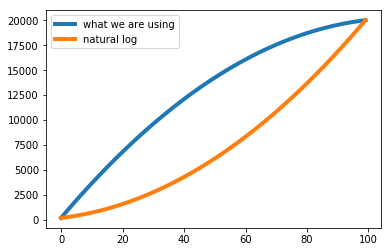

In [3]:
# demo the non-linear sampling of frequencies
plt.plot(expspace(200, 20000, 100, 'flip'), label='what we are using', lw=4)
plt.plot(expspace(200, 20000, 100, 'natural'), label='natural log', lw=4)
plt.legend()

In [24]:
import time
import pydsm  # for the adjustment between perceived amplitude and frequency
from scipy.io.wavfile import write

# params
fs=44100  # sample freq
duration=0.8
tone_length = 0.3  # desired length in seconds

# test this freq range
min_freq = 200
max_freq = 20000
n_freqs = ((max_freq - min_freq)*2)+1
n_freqs = 10
freqs = expspace(min_freq, max_freq, n_freqs, 'flip')

# (1) amplitude task

### for this, we use b-weighting to adjust the perceptual volume across frequencies
### the task will be for people to say whether or not a tone was present, so we can map their auditory acuity
### we will test 10 frequencies (200-20,000Hz), 5 amplitudes, with 4 repetitions

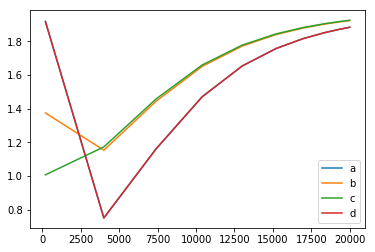

In [25]:
# which method of correcting for perceptual amplitude?
freqs_to_plot = expspace(200, 20000, 10, 'flip')

base_amp = pydsm.audio_weightings.a_weighting(freqs_to_plot)
plt.plot(freqs_to_plot, (1-base_amp)+1, label='a')
base_amp = pydsm.audio_weightings.b_weighting(freqs_to_plot)
plt.plot(freqs_to_plot, (1-base_amp)+1, label='b')
base_amp = pydsm.audio_weightings.c_weighting(freqs_to_plot)
plt.plot(freqs_to_plot, (1-base_amp)+1, label='c')
base_amp = pydsm.audio_weightings.a_weighting(freqs_to_plot)
plt.plot(freqs_to_plot, (1-base_amp)+1, label='d')
plt.legend()
plt.show()

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in divide


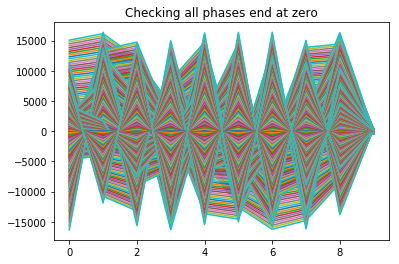

In [27]:
base_dir = '/Users/lauragwilliams/Documents/experiments/shepard/shepard/pretests/amp_forben'

# we should test different amplitudes depending on the freq. we weight
# the amplitude based on standard 
base_amp = pydsm.audio_weightings.b_weighting(freqs)
amp_corrections = (1-base_amp)+1

duration = 0.3
# test this amp range
min_amp = 0.
max_amp = 0.5
n_amps = 50

# make tones, looping through each paramtere
for amp_cor, freq in zip(amp_corrections, freqs):
    for amps in np.linspace(min_amp, max_amp, n_amps):

        # make tone
        tone = complex_tone([freq], [amps*amp_cor], duration)
        tone = truncate_phase(tone)
        tone = np.int16(tone/np.max(np.abs(tone)) * 32767)
        
#         play_sound(tone)
#         play_sound(tone[100:int(fs*tone_length)+100])
        
        tone = tone*amps

        # save to disk
        fname = '%s/%s-%s.wav' % (base_dir, np.round(freq), np.round(amps, 3))
#         write(fname, fs, tone[0:int(fs*tone_length)])
        write(fname, fs, tone)


        plt.plot(tone[-10:])
plt.title('Checking all phases end at zero')
plt.show()

In [22]:
freqs

array([  200.,  4000.,  7400., 10400., 13000., 15200., 17000., 18400.,
       19400., 20000.])

# (2) Pitch
### here, we will also to a 2AFC, presenting ptps with different tones, and asking if the pitch is the same or different
### we will use all semitones, and contrast them with the same, and up to one semitone away, in 25 cent increments
### we use this table to get the semitone frequencies: https://pages.mtu.edu/~suits/notefreqs.html

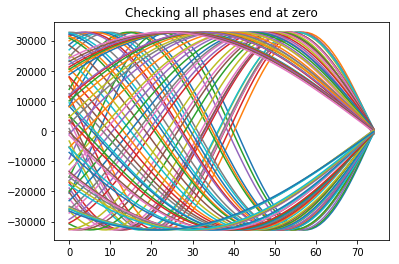

In [22]:
base_dir = '/Users/lauragwilliams/Documents/experiments/shepard/shepard/pretests/pitch'

semitones = np.array([659, 624, 587, 554, 524, 494, 466, 440, 415, 392, 370, 349, 330, 311, 294, 277, 262, 247, 233, 220, 208])
plus_minus = np.linspace(0, 10, 5)  # spacing between tones

duration = 0.3
amp = 0.08
amp = 0.02


# loop through each semitone
for ii in range(len(semitones)):
    
    # loop intil one minus the end
    if ii != len(semitones)-1:
        # pull out relevant tones
        tone_0 = semitones[ii]
        tone_1 = semitones[ii+1]

        # get thirds differnce in freq between the tones
        freq_diff = (tone_0 - tone_1)/4.

        # make tone at this pitch
        for jj in range(4):
            adjustment = freq_diff*jj
            this_tone = tone_0 - adjustment
            adjusted_tone1 = complex_tone([this_tone], [amp], duration)
            adjusted_tone1 = truncate_phase(adjusted_tone1)
            adjusted_tone1 = np.int16(adjusted_tone1/np.max(np.abs(adjusted_tone1)) * 32767)

            # save to disk
            fname = '%s/%s-%s.wav' % (base_dir, np.round(this_tone, 2), jj)
#             write(fname, fs, adjusted_tone1[0:int(fs*tone_length)])
#             write(fname, fs, adjusted_tone1)
            plt.plot(adjusted_tone1[-75:])


    
    else:
            this_tone = semitones[-1]
            adjusted_tone1 = complex_tone([this_tone], [amp], duration)
            adjusted_tone1 = truncate_phase(adjusted_tone1)
            adjusted_tone1 = np.int16(adjusted_tone1/np.max(np.abs(adjusted_tone1)) * 32767)

            # save to disk
            fname = '%s/%s-%s.wav' % (base_dir, np.round(this_tone, 2), 0)
#             write(fname, fs, adjusted_tone1)

            plt.plot(adjusted_tone1[-75:])
plt.title('Checking all phases end at zero')
plt.show()